# Network Visualization (PyTorch)

In this notebook we will explore the use of *image gradients* for generating new images.

When training a model, we define a loss function which measures our current unhappiness with the model's performance; we then use backpropagation to compute the gradient of the loss with respect to the model parameters, and perform gradient descent on the model parameters to minimize the loss.

Here we will do something slightly different. We will start from a convolutional neural network model which has been pretrained to perform image classification on the ImageNet dataset. We will use this model to define a loss function which quantifies our current unhappiness with our image, then use backpropagation to compute the gradient of this loss with respect to the pixels of the image. We will then keep the model fixed, and perform gradient descent *on the image* to synthesize a new image which minimizes the loss.

In this notebook we will explore three techniques for image generation:

1. **Saliency Maps**: Saliency maps are a quick way to tell which part of the image influenced the classification decision made by the network.
2. **Fooling Images**: We can perturb an input image so that it appears the same to humans, but will be misclassified by the pretrained network.
3. **Class Visualization**: We can synthesize an image to maximize the classification score of a particular class; this can give us some sense of what the network is looking for when it classifies images of that class.

This notebook uses **PyTorch**; we have provided another notebook which explores the same concepts in TensorFlow. You only need to complete one of these two notebooks.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
import random
import numpy as np
from scipy.ndimage.filters import gaussian_filter1d
import matplotlib.pyplot as plt
from cs231n.image_utils import SQUEEZENET_MEAN, SQUEEZENET_STD
from PIL import Image
import glob
import os.path as osp

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'


In [2]:
# Use GPU if available, otherwise stick with cpu
use_cuda = torch.cuda.is_available()
torch.manual_seed(123)
device = torch.device(cuda if use_cuda else "cpu")
print(device)

cpu


### Helper Functions

Our pretrained model was trained on images that had been preprocessed by subtracting the per-color mean and dividing by the per-color standard deviation. We define a few helper functions for performing and undoing this preprocessing. You don't need to do anything in this cell.

In [3]:
def preprocess(img, size=300):
    transform = T.Compose([
        T.Resize(size),
        T.ToTensor(),
        T.Normalize(mean=SQUEEZENET_MEAN.tolist(),
                    std=SQUEEZENET_STD.tolist()),
        T.Lambda(lambda x: x[None]),
    ])
    return transform(img)

def deprocess(img, should_rescale=True):
    transform = T.Compose([
        T.Lambda(lambda x: x[0]),
        T.Normalize(mean=[0, 0, 0], std=(1.0 / SQUEEZENET_STD).tolist()),
        T.Normalize(mean=(-SQUEEZENET_MEAN).tolist(), std=[1, 1, 1]),
        T.Lambda(rescale) if should_rescale else T.Lambda(lambda x: x),
        T.ToPILImage(),
    ])
    return transform(img)

def rescale(x):
    low, high = x.min(), x.max()
    x_rescaled = (x - low) / (high - low)
    return x_rescaled
    
def blur_image(X, sigma=1):
    X_np = X.cpu().clone().numpy()
    X_np = gaussian_filter1d(X_np, sigma, axis=2)
    X_np = gaussian_filter1d(X_np, sigma, axis=3)
    X.copy_(torch.Tensor(X_np).type_as(X))
    return X

In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=3, stride=1,padding=1) #(300+1x2-3)/1+1=300  300x300x10 pool 150x150x10
        self.conv2 = nn.Conv2d(10, 20, kernel_size=3, stride=1,padding=1) #(150+1x2-3)/1+1=150  150x150x10 pool 75x75x20
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(75*75*20, 740*3)  #75x75x20 
        self.fc2 = nn.Linear(740*3, 740) #740 total categories

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 75*75*20) # reshape 75x75x20
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

model = Net().to(device)
#optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [5]:
def save_checkpoint(checkpoint_path, model, optimizer):
    state = {'state_dict': model.state_dict(),
             'optimizer' : optimizer.state_dict()}
    torch.save(state,checkpoint_path)
    print('model saved to %s' % checkpoint_path)
    
def load_checkpoint(checkpoint_path, model, optimizer):
    state = torch.load(checkpoint_path)
    model.load_state_dict(state['state_dict'])
    optimizer.load_state_dict(state['optimizer'])
    print('model loaded from %s' % checkpoint_path)

In [6]:
# create a new model
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# load from the final checkpoint
load_checkpoint('model_training99p_test14p/pdbss-ATOMS-6000.pth', model, optimizer)
# should give you the final model accuracy
#test()

model loaded from model_training99p_test14p/pdbss-ATOMS-6000.pth


# Pretrained Model

For all of our image generation experiments, we will start with a convolutional neural network which was pretrained to perform image classification on ImageNet. We can use any model here, but for the purposes of this assignment we will use SqueezeNet [1], which achieves accuracies comparable to AlexNet but with a significantly reduced parameter count and computational complexity.

Using SqueezeNet rather than AlexNet or VGG or ResNet means that we can easily perform all image generation experiments on CPU.

[1] Iandola et al, "SqueezeNet: AlexNet-level accuracy with 50x fewer parameters and < 0.5MB model size", arXiv 2016

In [7]:
# Download and load the pretrained SqueezeNet model.
# (HW3) model = torchvision.models.squeezenet1_1(pretrained=True)
# (project) done above

# We don't want to train the model, so tell PyTorch not to compute gradients
# with respect to model parameters.
for param in model.parameters():
    param.requires_grad = False
    
# you may see warning regarding initialization deprecated, that's fine, please continue to next steps

## Load some ImageNet images
We have provided a few example images from the validation set of the ImageNet ILSVRC 2012 Classification dataset. To download these images, descend into `cs231n/datasets/` and run `get_imagenet_val.sh`.

Since they come from the validation set, our pretrained model did not see these images during training.

Run the following cell to visualize some of these images, along with their ground-truth labels.

In [8]:
f_cat = open('/Users/user/cs231n_Database_dir/Simple_Category_List.txt','r')
class_names = [x.strip() for x in f_cat.readlines()]
class_names[0:0] = 'n'
print(class_names)

['n', '2_1_COMPND_REMARK_ATOM_HEADER', '2_1_COMPND_REMARK_TITLE_HEADER', '2_1_COMPND_SOURCE_HEADER', '2_1_HEADER', '2_1_HEADER_COMPND', '2_1_HEADER_COMPND_AUTHOR_JRNL', '2_1_HEADER_COMPND_REMARK_JRNL', '2_1_HEADER_COMPND_SOURCE_EXPDTA', '2_1_HEADER_DBREF', '2_1_HEADER_JRNL', '2_1_HEADER_KEYWDS_AUTHOR_REMARK', '2_1_HEADER_REMARK', '2_1_HEADER_REMARK_DBREF', '2_1_JRNL_HEADER', '2_2_1_DBREF_HEADER', '2_2_1_EXPDTA_KEYWDS_HEADER', '2_2_1_HEADER', '2_2_1_HETATM_SEQADV_HEADER_SOURCE', '2_2_1_JRNL_KEYWDS_HEADER', '2_2_1_JRNL_KEYWDS_HEADER_HETNAM', '2_2_1_KEYWDS_HEADER', '2_2_1_SEQADV_KEYWDS_HEADER', '2_2_1_SEQADV_KEYWDS_HEADER_HELIX', '2_2_2_KEYWDS_HEADER_CONECT', '2_2_2_KEYWDS_HEADER_CONECT_LINK', '2_2_2_SEQADV_JRNL_KEYWDS_HEADER', '2_2_3_DBREF_CRYST1_HEADER_TER', '2_2_3_DBREF_KEYWDS_HEADER_MODRES', '2_2_3_HEADER', '2_2_3_HEADER_MODRES_CONECT_LINK', '2_2_3_HEADER_MODRES_LINK_ATOM', '2_2_3_HETATM_JRNL_KEYWDS_HEADER', '2_2_3_JRNL_KEYWDS_HEADER', '2_2_3_JRNL_KEYWDS_HEADER_TER', '2_2_3_SEQADV_HEA

In [10]:
target_y = 135
print(class_names[target_y])

APOPTOSIS,_HYDROLASE


In [11]:
import imageio

def show_some_image(category_id, train_or_test, repeat): 
    plt.figure(figsize=(24, 12))

    for i in range(repeat):
        root = osp.join('/Users/user/cs231n_Database_dir/CS231N_PDB_SNAPSHOTS_DATABASE_5000_ATOMS',str(train_or_test))
        filenames_train = glob.glob(osp.join(root, str(category_id), '*.png'))
        num_files = len(filenames_train)
        pick_file = np.random.randint(num_files+1)
        pick_filename = filenames_train[pick_file]
        print(pick_filename)
        img = imageio.imread(pick_filename)
        plt.subplot(repeat,1,i+1)
        plt.imshow(img)


/Users/user/cs231n_Database_dir/CS231N_PDB_SNAPSHOTS_DATABASE_5000_ATOMS/train/135/1NME_x06.png
/Users/user/cs231n_Database_dir/CS231N_PDB_SNAPSHOTS_DATABASE_5000_ATOMS/train/135/1NME_x25.png
/Users/user/cs231n_Database_dir/CS231N_PDB_SNAPSHOTS_DATABASE_5000_ATOMS/train/135/1NMS_x16.png


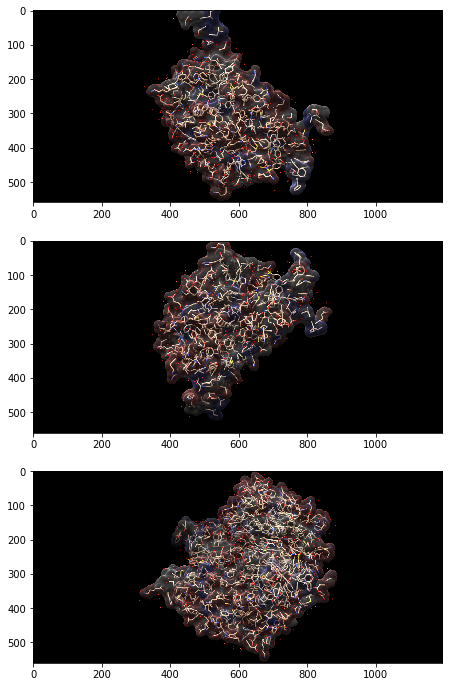

In [12]:
show_some_image(135,'train',3)  # "APOPTOSIS,_HYDROLASE"

/Users/user/cs231n_Database_dir/CS231N_PDB_SNAPSHOTS_DATABASE_5000_ATOMS/test/135/1NMQ_x27.png
/Users/user/cs231n_Database_dir/CS231N_PDB_SNAPSHOTS_DATABASE_5000_ATOMS/test/135/1NMQ_y10.png
/Users/user/cs231n_Database_dir/CS231N_PDB_SNAPSHOTS_DATABASE_5000_ATOMS/test/135/1NMQ_x24.png


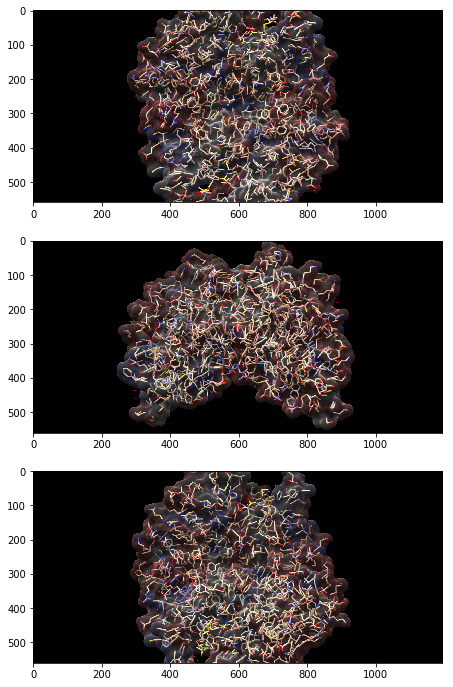

In [13]:
show_some_image(135,'test',3)  # "APOPTOSIS,_HYDROLASE"

In [14]:
#from cs231n.data_utils import load_imagenet_val
#X, y, class_names = load_imagenet_val(num=5)

#plt.figure(figsize=(12, 6))
#for i in range(5):
#    plt.subplot(1, 5, i + 1)
#    plt.imshow(X[i])
#    plt.title(class_names[y[i]])
#    plt.axis('off')
#plt.gcf().tight_layout()

# Class visualization
By starting with a random noise image and performing gradient ascent on a target class, we can generate an image that the network will recognize as the target class. This idea was first presented in [2]; [3] extended this idea by suggesting several regularization techniques that can improve the quality of the generated image.

Concretely, let $I$ be an image and let $y$ be a target class. Let $s_y(I)$ be the score that a convolutional network assigns to the image $I$ for class $y$; note that these are raw unnormalized scores, not class probabilities. We wish to generate an image $I^*$ that achieves a high score for the class $y$ by solving the problem

$$
I^* = \arg\max_I (s_y(I) - R(I))
$$

where $R$ is a (possibly implicit) regularizer (note the sign of $R(I)$ in the argmax: we want to minimize this regularization term). We can solve this optimization problem using gradient ascent, computing gradients with respect to the generated image. We will use (explicit) L2 regularization of the form

$$
R(I) = \lambda \|I\|_2^2
$$

**and** implicit regularization as suggested by [3] by periodically blurring the generated image. We can solve this problem using gradient ascent on the generated image.

In the cell below, complete the implementation of the `create_class_visualization` function.

[2] Karen Simonyan, Andrea Vedaldi, and Andrew Zisserman. "Deep Inside Convolutional Networks: Visualising
Image Classification Models and Saliency Maps", ICLR Workshop 2014.

[3] Yosinski et al, "Understanding Neural Networks Through Deep Visualization", ICML 2015 Deep Learning Workshop

In [15]:
def jitter(X, ox, oy):
    """
    Helper function to randomly jitter an image.
    
    Inputs
    - X: PyTorch Tensor of shape (N, C, H, W)
    - ox, oy: Integers giving number of pixels to jitter along W and H axes
    
    Returns: A new PyTorch Tensor of shape (N, C, H, W)
    """
    if ox != 0:
        left = X[:, :, :, :-ox]
        right = X[:, :, :, -ox:]
        X = torch.cat([right, left], dim=3)
    if oy != 0:
        top = X[:, :, :-oy]
        bottom = X[:, :, -oy:]
        X = torch.cat([bottom, top], dim=2)
    return X

In [16]:
def create_class_visualization(target_y, model, dtype, **kwargs):
    """
    Generate an image to maximize the score of target_y under a pretrained model.
    
    Inputs:
    - target_y: Integer in the range [0, 1000) giving the index of the class
    - model: A pretrained CNN that will be used to generate the image
    - dtype: Torch datatype to use for computations
    
    Keyword arguments:
    - l2_reg: Strength of L2 regularization on the image
    - learning_rate: How big of a step to take
    - num_iterations: How many iterations to use
    - blur_every: How often to blur the image as an implicit regularizer
    - max_jitter: How much to gjitter the image as an implicit regularizer
    - show_every: How often to show the intermediate result
    """
    model.type(dtype)
    l2_reg = kwargs.pop('l2_reg', 1e-3)
    learning_rate = kwargs.pop('learning_rate', 25)
    #num_iterations = kwargs.pop('num_iterations', 100)
    num_iterations = kwargs.pop('num_iterations', 500)
    blur_every = kwargs.pop('blur_every', 10)
    max_jitter = kwargs.pop('max_jitter', 16)
    show_every = kwargs.pop('show_every', 25)

    # Randomly initialize the image as a PyTorch Tensor, and make it requires gradient.
    img = torch.randn(1, 3, 300, 300).mul_(1.0).type(dtype).requires_grad_()

    for t in range(num_iterations):
        # Randomly jitter the image a bit; this gives slightly nicer results
        ox, oy = random.randint(0, max_jitter), random.randint(0, max_jitter)
        img.data.copy_(jitter(img.data, ox, oy))

        ########################################################################
        # TODO: Use the model to compute the gradient of the score for the     #
        # class target_y with respect to the pixels of the image, and make a   #
        # gradient step on the image using the learning rate. Don't forget the #
        # L2 regularization term!                                              #
        # Be very careful about the signs of elements in your code.            #
        ########################################################################

        scores = model(img)
        target_score = scores[0,target_y] 
        target_score.backward()
        
        im_grad = img.grad.data
        im_grad -= 2*l2_reg*img.data
        
        img.data += learning_rate * im_grad / im_grad.norm() 
        img.grad.data.zero_()
        
        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################
        
        # Undo the random jitter
        img.data.copy_(jitter(img.data, -ox, -oy))

        # As regularizer, clamp and periodically blur the image
        for c in range(3):
            lo = float(-SQUEEZENET_MEAN[c] / SQUEEZENET_STD[c])
            hi = float((1.0 - SQUEEZENET_MEAN[c]) / SQUEEZENET_STD[c])
            img.data[:, c].clamp_(min=lo, max=hi)
        if t % blur_every == 0:
            blur_image(img.data, sigma=0.5)
        
        # Periodically show the image
        if t == 0 or (t + 1) % show_every == 0 or t == num_iterations - 1:
            plt.imshow(deprocess(img.data.clone().cpu()))
            class_name = class_names[target_y]
            plt.title('%s\nIteration %d / %d' % (class_name, t + 1, num_iterations))
            plt.gcf().set_size_inches(4, 4)
            plt.axis('off')
            plt.show()

    return deprocess(img.data.cpu())

Once you have completed the implementation in the cell above, run the following cell to generate an image of a Tarantula:

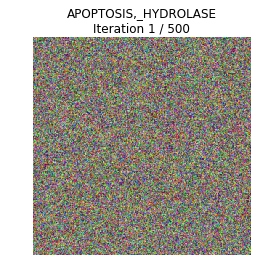

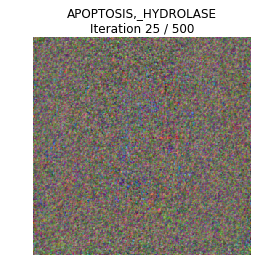

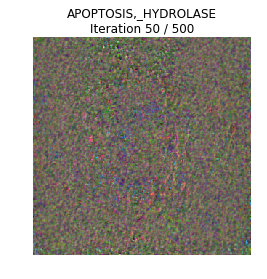

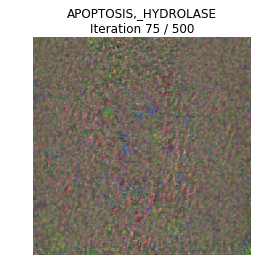

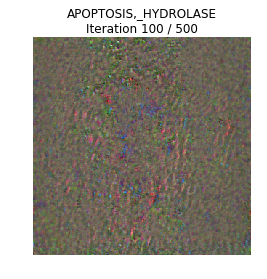

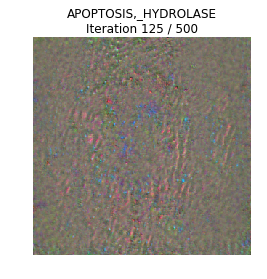

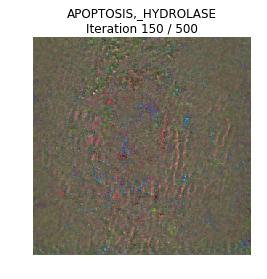

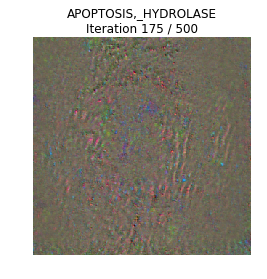

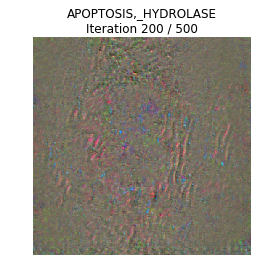

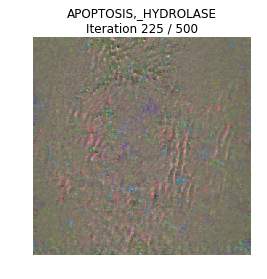

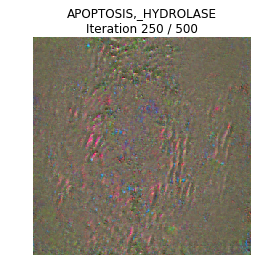

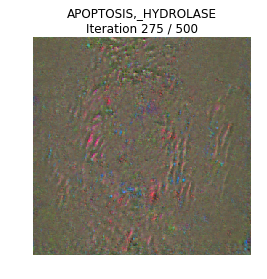

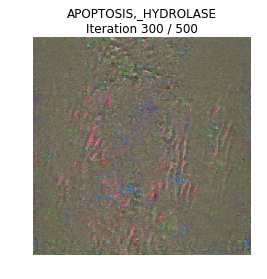

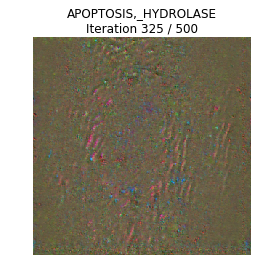

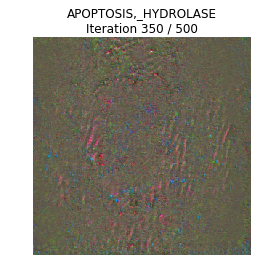

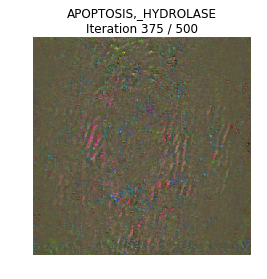

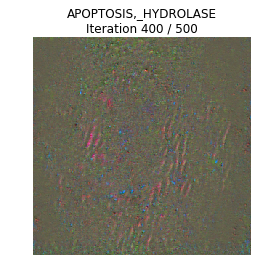

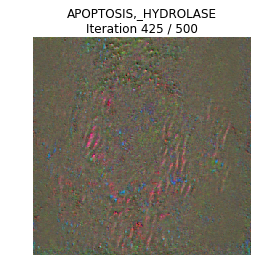

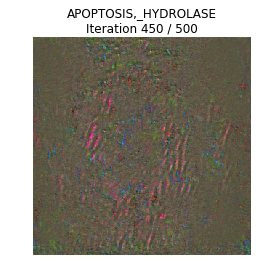

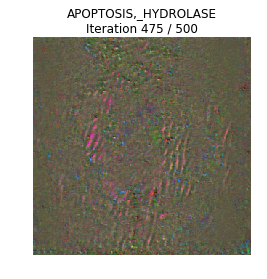

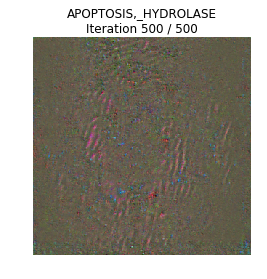

In [17]:
dtype = torch.FloatTensor
# dtype = torch.cuda.FloatTensor # Uncomment this to use GPU
model.type(dtype)

#target_y = 100 # "8_1_HEADER_SOURCE_KEYWRDS_REMARK"
target_y = 135 # "APOPTOSIS,_HYDROLASE"
out = create_class_visualization(target_y, model, dtype)

Try out your class visualization on other classes! You should also feel free to play with various hyperparameters to try and improve the quality of the generated image, but this is not required.

In [32]:
imageio.imsave('class_visualization_target_y_135.jpg',np.array(out))

In [ ]:
target_y = 322
print(class_names[target_y])

In [ ]:
show_some_image(target_y,'train',3)  # "GENE_REGULATION/RNA/DNA"

In [ ]:

target_y = np.random.randint(740+1)
print(target_y)
print(class_names[target_y])
X = create_class_visualization(target_y, model, dtype)

In [ ]:
imsave('class_visualization_target_y_322.jpg',np.array(out))